In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *


In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
varinfo.clear()

In [4]:
module = fc.eightb.preselection.t8btag_minmass
dout = "yy_quadh"

In [5]:
altfile="yy_quadh_bkg10_soft025_md_allsig_{base}"
# signal = ObjIter([])
signal = ObjIter([ Tree(f, report=False, altfile=altfile) for f in tqdm(module.signal_list) ])
# signal = ObjIter([ Tree(f, report=False) for f in tqdm(module.full_signal_list) ])

# bkg = ObjIter([])
bkg = ObjIter([ Tree(module.Run2_UL18.QCD_B_List, altfile=altfile), Tree(module.Run2_UL18.TTJets, altfile=altfile)])

data = ObjIter([])
# data = ObjIter([ Tree(module.Run2_UL18.JetHT_Data_UL_List) ])

100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


In [6]:
analysis = Analysis.__subclasses__()[4](
    signal=signal, bkg=bkg, data=data,
    sr_r=0.5, cr_r=1.0,
    # use_signal=[0,-2,-1]
)

In [7]:
analysis.run(runlist=['build_abcd'])

[running] reweight_bkg
[running] jet_kin_cuts
[skipping] plot_ranker
[skipping] plot_t8btag_signal
[skipping] plot_eightb_signal
[skipping] plot_assigned_jet_kin
[skipping] plot_assigned_higgs_kin
[skipping] plot_assigned_y_kin
[skipping] plot_x_kin
[running] build_higgs_dm
Optimization terminated successfully.
         Current function value: 0.894833
         Iterations: 63
         Function evaluations: 157
[129.1  124.31 122.1  120.9 ]
[skipping] plot_assigned_higgs_m
[skipping] plot_y_higgs_m
[skipping] plot_abcd_variables
[running] build_abcd
[skipping] plot_abcd_regions
[skipping] var_correlations
[skipping] plot_vr_datamc
[skipping] train_vr_bdt
[skipping] train_ar_bdt
[skipping] calc_limits
[skipping] calc_brazil


In [8]:
signal = analysis.signal 
bkg = analysis.bkg 
data = analysis.data

100%|██████████| 1/1 [00:10<00:00, 10.24s/it]


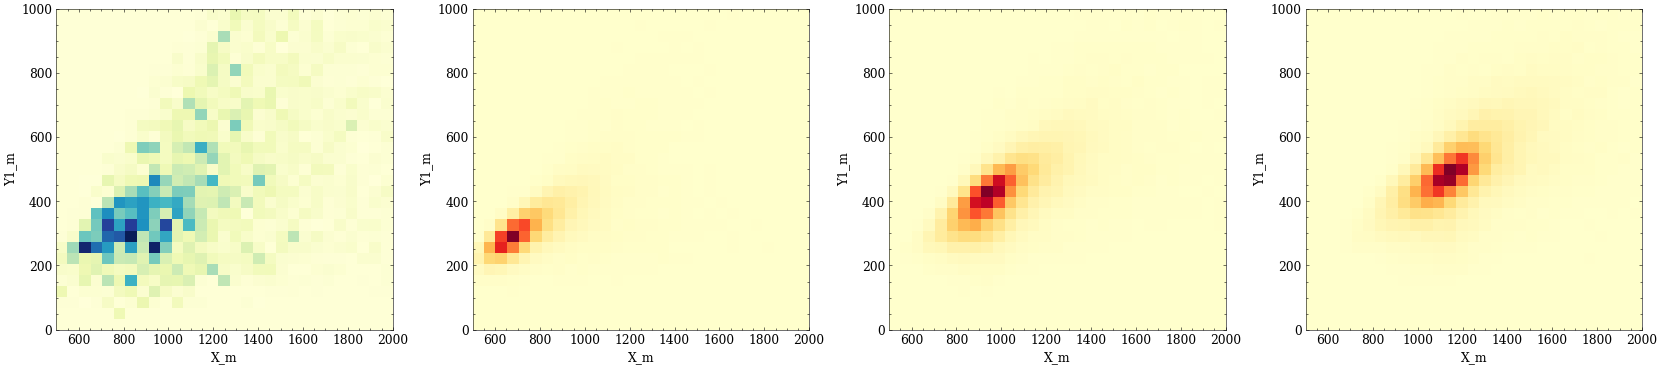

In [9]:
study.quick2d( 
    signal+bkg,
    varlist=['X_m','Y1_m'],
    binlist=[(500,2000,30),(0,1000,30)]
)

In [114]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.layers import Dense


encoded = [
    keras.Input(shape=(3,)),
    Dense( 32, activation='relu'),
    Dense( 16, activation='relu'),
    Dense(  8, activation='relu'),
    Dense(  1, activation='relu'),
]

decoded = [
    Dense(  8, activation='relu'),
    Dense( 16, activation='relu'),
    Dense( 32, activation='relu'),
    Dense(  3, activation='linear'),
]

encoder = keras.Sequential(encoded)
autoencoder = keras.Sequential(encoded+decoded)

In [115]:
autoencoder.compile(optimizer='adam', loss=keras.losses.MeanSquaredError())

In [116]:
def get_inputs(t):
    X = t.X_m, t.Y1_m, t.Y2_m
    return np.log(np.abs( np.stack(X, axis=1) ))

dataset = bkg.apply(get_inputs).cat.to_numpy()

In [117]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(dataset, test_size=0.2)

In [118]:
scaler = StandardScaler().fit(train)

x_train, x_test = scaler.transform(train), scaler.transform(test)

In [120]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
75/75 [==============================] - 0s 4ms/step - loss: 0.2506 - val_loss: 0.2547
Epoch 2/50
75/75 [==============================] - 0s 3ms/step - loss: 0.2505 - val_loss: 0.2549
Epoch 3/50
75/75 [==============================] - 0s 3ms/step - loss: 0.2499 - val_loss: 0.2544
Epoch 4/50
75/75 [==============================] - 0s 3ms/step - loss: 0.2501 - val_loss: 0.2564
Epoch 5/50
75/75 [==============================] - 0s 3ms/step - loss: 0.2511 - val_loss: 0.2550
Epoch 6/50
75/75 [==============================] - 0s 4ms/step - loss: 0.2506 - val_loss: 0.2548
Epoch 7/50
75/75 [==============================] - 0s 4ms/step - loss: 0.2500 - val_loss: 0.2542
Epoch 8/50
75/75 [==============================] - 0s 3ms/step - loss: 0.2500 - val_loss: 0.2540
Epoch 9/50
75/75 [==============================] - 0s 4ms/step - loss: 0.2499 - val_loss: 0.2546
Epoch 10/50
75/75 [==============================] - 0s 4ms/step - loss: 0.2506 - val_loss: 0.2541
Epoch 11/50
75/75 [

In [121]:
def encoded_xy(t):
    inputs = get_inputs(t)
    inputs = scaler.transform(inputs)
    t.extend(
        encoded_xy=ak.from_regular(encoder.predict(inputs)[:,0])
    ) 

In [122]:
(signal+bkg).apply(encoded_xy)

513/513 [==============================] - 1s 1ms/step


[None, None, None, None, None]

100%|██████████| 2/2 [00:40<00:00, 20.38s/it]


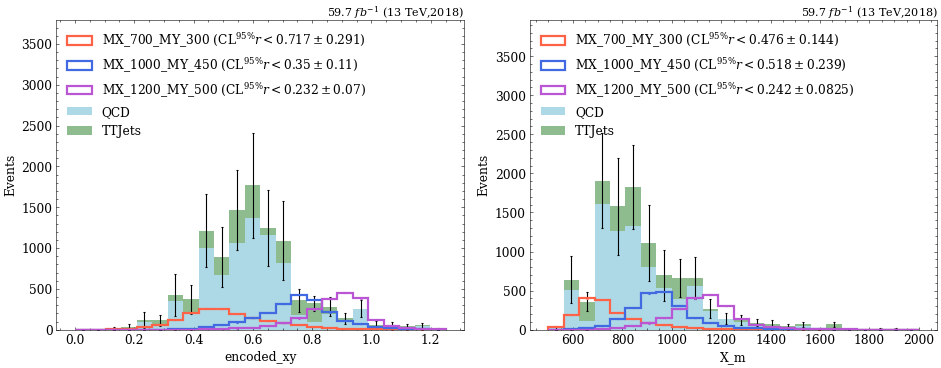

In [126]:
study.quick( 
    signal+bkg,
    masks=analysis.ar_bdt.a,
    varlist=['encoded_xy','X_m'],
    binlist=[(0,1.25,25),(500,2000,25)],
    # efficiency=True,
    limits=True,
    legend=True,
)